In [1]:
%run grader_funs.py

All imports complete from py file


Manually convert the dat file into an excel file using excel. Only extract the serial number,
name and Answers, and make sure Answers is text.
**Serial number should not be text**

In [2]:
#COLLECTING DATA
## The code will calculate automatically whether to use All or All_fakes (It will use All_fakes only if All if not available. 
## Use the following lines only to over-ride this)
# rawdatafilename='All'
# datafilename=rawdatafilename+'.xlsx'

rawdatafilename = ''
if os.path.exists("All.xlsx"):
    rawdatafilename='All'
    datafilename=rawdatafilename+'.xlsx'
    trash_files('*fake*')

if os.path.exists("All_fakes.xlsx"):
    rawdatafilename='All_fakes'
    datafilename=rawdatafilename+'.xlsx'

assert rawdatafilename, "Make sure either All or All_fakes is ready"
print("Using data from {}.xlsx".format(rawdatafilename))


gradebook='BSGrades.csv'
assert(os.path.isfile(datafilename)),'Make sure '+datafilename+" is ready"
assert(os.path.isfile(gradebook)),'Make sure '+gradebook+' is ready'

df = pd.read_excel(datafilename, header=None, usecols=[0,1,2], names = ["Srl No", "Name", "Answers"], dtype='str')
#parse_cols makes sure that only cols 0,1 and 2 are extracted
just_answers_df=df.loc[:,"Answers"]
#checking for blanks, print only if blanks found
asterisks = False
blankers=df[df['Answers'].str.contains(" ")]
stars = df[df['Answers'].str.contains('\*')]
if not blankers.empty:
    print("The following scantrons had blanks in them. Please resolve before proceeding.")
    display(blankers)
if not stars.empty:
    print("The following scantrons were flagged as unclear. Please resolve before proceeding.")
    display(stars)
    asterisks = True
ER=check_serial_numbers(gradebook,datafilename)
if not ER.empty:
    display(ER)

df["Missed"] = ""
df["Score"]=0
df["Percentage"]=np.nan
number_of_questions_from_scantrons=len(df.loc[0,"Answers"])

All_fakes.xlsx removed
All *fake* Removed!
Using data from All.xlsx
The following scantrons had blanks in them. Please resolve before proceeding.


,Srl No,Name,Answers
125,1139,MICHAEL FINN-HENRY,22311120432223200 30311120
143,1158,EDUARD TATARU,04334 00304114333014142231


,Registered Name,Srl No,Entered Name
1,Aburto Julio Luis,1054,NaN
20,Choi Ryan,1061,NaN
145,Zisengwe Franklin,1075,NaN
21,Choi Harry,1086,CHOI WOONGJAE
22,Choi Harry,1086,CHOI WOONGJAE


In [3]:
assert not asterisks, "Please resolve the answerkeys with *'s in them before proceeding'"


##################### Free or skipped questions######################
freebies=[]#enter ACTUAL QUESTION NUMBER of questions from version 0(A) to which to award full credit regardless of response
skipped_questions=[]#enter ACTUAL QUESTION NUMBER of questions from version 0(A) to which to skip
#####################################################################


points_per_question=3
#determining whether the test in question is a final or a midterm. 3 points dropped for a final and 2 points dropped for a midterm
tstfiles=glob.glob("*.tst")
tstname = tstfiles[0][:-5]
 
if bool([x for x in tstfiles if "final" in x.lower()]):
    point_drop = 3
    print("Grading out of total - 3 since this is the final.")
else:
    point_drop = 2
    print("Grading out of total - 2 since this is a midterm.")


assert os.path.exists(tstname+"0.txt") |  os.path.exists("key0.txt"), "answerkey0 not found. Make sure it is named key0.txt or something like 2019_test1v0.txt"
  
if not os.path.exists(tstname+"0.txt"):
        tstname = "key"
print("Assuming answerkey files are in the .txt files named {}".format(tstname))      
    

if freebies:
    print("{} questions are being awarded free points!".format(len(freebies)).upper())


if skipped_questions:
    print("{} questions are being skipped!".format(len(skipped_questions)).upper())

quids_dfs=createQuestionIDs_and_dfs(tstname, max_words=50)
QIDs=quids_dfs["IDs"]
exempts=make_special_question_list(freebies, QIDs)
skipped = make_special_question_list(skipped_questions, QIDs)

outs = getAllKeys(tstname, points_per_question, skipped)
keylist=outs["keylist"]
pointlist=outs["pointlist"]
numberOfQuestions=outs["numberOfQuestions"]
assert number_of_questions_from_scantrons == numberOfQuestions, "The number of questions on the test ({}) does not match the number of questions on the scantron ({})".format(numberOfQuestions,number_of_questions_from_scantrons)
assert sum(pointlist[0]) == sum(pointlist[1]) ==sum(pointlist[2]) == sum(pointlist[3]), "Total number of points on each version should be the same"
totalpoints=sum(pointlist[2])
new_totalpoints=totalpoints-point_drop
numberOfVersions=len(keylist)
numberOfStudents=df.shape[0]

koschen_paper=quids_dfs['dfs']
v0_question_list = list(koschen_paper[0].loc[:,"Question"]) #List of questions in version 0
assert(keylist and pointlist and QIDs and koschen_paper and numberOfQuestions!=0),"Either keylist or pointlist or QIDs or koschen_paper or  numberOfQuestions is null"


analysis_df  = pd.DataFrame(index=range(numberOfStudents),columns = list(QIDs[0])+["score"])# stores whether answer was correct, questions are the columns, last column is the score


Grading out of total - 3 since this is the final.
Assuming answerkey files are in the .txt files named 2019fall-final_v
Generating QIDs. This might take a while..
Done. That took: 3.117309808731079 sec.


In [4]:
##Everything initialized. Running the code now
# too_few_answers =  df[df['Answers'].map(len)<numberOfQuestions-1]
# too_many_answers =  df[df['Answers'].map(len)>numberOfQuestions]
# stranges = [too_few_answers, too_many_answers]
# too_many_or_too_few = False
# for strange in stranges:
#     if not strange.empty:
#         display(strange[['Srl No', 'Name','Answers']])
#         too_many_or_too_few = True
# assert not too_many_or_too_few, "Check that all answer strings have correct length"   

incorrect_length =  df[(df['Answers'].map(len)<numberOfQuestions-1) | (df['Answers'].map(len)>numberOfQuestions)]
if not incorrect_length.empty:
    incorrect_length=incorrect_length[['Srl No', 'Name','Answers']]
    print("The following students had too many or too few answers")
    display(incorrect_length)
assert incorrect_length.empty, "Check that all answer strings have correct length" 

last_entry_missing=df[df['Answers'].map(len)==numberOfQuestions-1]
if not last_entry_missing.empty:
    last_entry_missing=last_entry_missing[['Srl No', 'Name','Answers']]
    print("The following students had no entry for the version question")
    display(last_entry_missing)
last_entry_space = df[(df['Answers'].str[-1] == ' ') & (df['Answers'].map(len) == numberOfQuestions)]
if not last_entry_space.empty:
    last_entry_space=last_entry_space[['Srl No', 'Name','Answers']]
    print("The following students had a blank entered for version question")
    display(last_entry_space)

print("Starting calculations...")
starttime = time()

df=process_grades(df,outs, QIDs ,analysis_df, new_totalpoints, numberOfVersions, analysis=True,exempt_questions=exempts,skipped_questions = skipped)
number_correct_by_version, students_by_version = analyse_items(df, koschen_paper,keylist)
item_analysis_df = make_item_analysis(analysis_df, v0_question_list) 
endtime = time()
print("Done. That took: "+str(endtime-starttime)+ " sec for "+str(numberOfStudents)+" students")
#check for duplicated serial numbers
dupes=df[df['Srl No'].duplicated(keep=False)]
if not dupes.empty:
    print('Warning: Duplicates in serial numbers found!')
    display(dupes)    
max_score=analysis_df.at[analysis_df['score'].idxmax(),'score']

Starting calculations...
Analysing data for version: A
Analysing data for version: B
Analysing data for version: C
Analysing data for version: D
Done. That took: 0.331434965133667 sec for 144 students


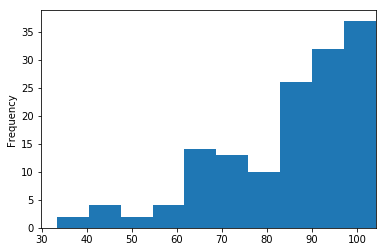

In [5]:
write_to_csv(df.sort_values('Score', ascending=False),rawdatafilename)
if (os.path.isfile('mystyle.css')):
    write_to_webpage(rawdatafilename, totalpoints, new_totalpoints,  df, item_analysis_df, point_drop, number_correct_by_version, students_by_version, list_of_free_qs=exempts, list_of_skipped_qs=skipped)
else:
    print("Copy the css file over first")

In [6]:
#Grades and displays the N'th entry in the list using a keylist
#N=random.randint(1,df.shape[0]-1)
# for N in range(df.shape[0]-1):
N=9
exempts=make_special_question_list(freebies, QIDs)
check1=gradeWithKeylist(df.iat[N,2], outs, QIDs, analysis_df, analysis=False, exempt_questions=exempts, skipped_questions=skipped)
print("Row "+ str(N)+": "+df.iat[N,1]+", "+str(df.iat[N,0])+". Missed "+str(check1['missed'])+ ". Scored "+str(check1['score'])+"/"+str(new_totalpoints))
print('That is: '+str(100*check1['score']/new_totalpoints)+'% with '+str(point_drop)+' points dropped')

Row 9: WITALEC MATTHEWD, 1010. Missed vA: ALL CORRECT. Scored 75/72
That is: 104.16666666666667% with 3 points dropped


In [ ]:
new_totalpoints

# DEVELOPMENT AREA
## All code below is in development


In [8]:
rawdatafilename

'All'